# Running APES on .raw files

This notebook contains an acoustic-only example of the Automatic Probabilistic Echo Solving (APES) approach. To further generalize the applications, this notebook applies the Bayesian inversion model using the PobabilisticEchoInversion package in Julia (see [Urmy et al., 2023](https://doi.org/10.1093/icesjms/fsad102)) to Kongsberg Simrad .raw files  and associated calibrations ingested using the pyEcholab python library.

### 1. User-defined inputs
Provide the location of the raw file(s) and associated Simrad .xml calibration files. Here, an example file and associated calibrations are provided in the data folder.

In [1]:
rawFileName = "data/raw/fm/DY2408-D20240611-T163138.raw" # Note, this example file is not included in the github repository
calFileName = "data/cal/fm/";

### 2. Set up environment
 - Activate and load Julia environment and associated packages
 - The `ProbabilisticEchoInversion` implementation of APES was designed for distributed computing, so workers are initilized
 - Initialize `pyEcholabReader`, the associated python module used for data ingestion and initial processing

In [2]:
using Pkg
# Activate the environment
Pkg.activate() 
# This will need to be run once if these packages are not already installed in the environment (this will take a while)
#Pkg.add.(["PythonCall","CSV", "DataFrames", "DataFramesMeta", "Plots","Glob","DimensionalData","ProbabilisticEchoInversion","Distributed","SDWBA","UnderwaterAcoustics"])

# Set up the environment variables used by PythonCall
ENV["JULIA_CONDAPKG_BACKEND"] = "Null" 
ENV["JULIA_PYTHONCALL_EXE"] = "/opt/conda/bin/python" # This shouldn't change?

# Load the required Julia packages
using PythonCall
using CSV, DataFrames, Plots
using Glob
using DimensionalData, DimensionalData.Dimensions
using DataFramesMeta
using ProbabilisticEchoInversion
using Distributed

# Set up distributed computing
addprocs(topology=:master_worker,exeflags="--project=$(Base.active_project())")

# Load the required Julia packages on all workers
@everywhere begin # on all of our workers....
    using ProbabilisticEchoInversion
    using SDWBA
    include(joinpath(@__DIR__, "../src/bubbles.jl"))
    using DimensionalData
    using DimensionalData.Dimensions: @dim, YDim, XDim
    using DataFrames
end


# Set the path for the python envieonment to the current directory
pyimport("sys").path.append(pwd())

# Import the pyEcholabReader module from the current directory
pyEcholabReader = pyimport("pyEcholabReader");

  Activating project at `/opt/julia/environments/v1.11`


### 3a. Read raw file(s) and conduct integration

`pyEcholabReader.integrationTable` returns a dataframe of columns `['interval','layer','frequency','mean_Sv']` containing the integrated volume backscattering strength by interval (horizontal) by layer (vertical). The following input parameters can be provided to modify the integration results:
 - raw_files (str): Path to raw files or directory containing raw files
 - cal_file (str): Path to calibration file or directory (optional)
 - interval_axis (str): Axis to use for integration intervals (default 'ping_number')
 - interval_length (int): Length of integration intervals (default 50)
 - layer_axis (str): Axis to use for integration layers (default 'range')
 - layer_thickness (int): Thickness of integration layers (default 5)
 - surf_offset (float/int/str): Surface exclusion offset (default 2)
 - bot_offset (float): Bottom exclusion offset (default 0.5)

The interval axes can be specified according to pyEcholab gridding protocol. Note that the returned dataframe is a `Py` datatype.

In [3]:
bigDF = pyEcholabReader.integrationTable(rawFileName,calFileName,pulse="FM",surf_offset=5, bot_offset=5)
print("Dataframe data type: $(typeof(bigDF))")
display(bigDF.head())

Dataframe data type: Py

,interval,layer,frequency,mean_Sv
0,0.0,0.0,34000.0,NaN
1,0.0,0.0,34099.0,NaN
2,0.0,0.0,34198.0,NaN
3,0.0,0.0,34297.0,NaN
4,0.0,0.0,34396.0,NaN


### 3b. Convert datatype to Julia dataframe

In [4]:
function convert_pandas_to_df_float(py_df)
    # Convert a pandas DataFrame to a Julia DataFrame, converting numeric columns to Float64

    # Get column names
    colnames = Symbol.(collect(py_df.columns))
    
    # Initialize data dictionary
    data = Dict{Symbol, Any}()
    
    # Process each column
    for name in py_df.columns
        col_data = collect(py_df[name])
        
        # Check if column appears to be numeric
        if all(x -> pyisinstance(x, pybuiltins.float) || 
                   pyisinstance(x, pybuiltins.int) || 
                   pyis(x, pybuiltins.None), col_data)
            # Convert to Float64, handling None/NaN values
            data[Symbol(name)] = [pyis(x, pybuiltins.None) ? NaN : pyconvert(Float64, x) for x in col_data]
        else
            # Keep as is for non-numeric columns
            data[Symbol(name)] = col_data
        end
    end
    
    return DataFrame(data)
end

bigDF = convert_pandas_to_df_float(bigDF);

print("Dataframe data type: $(typeof(bigDF))")
display(first(bigDF,5))

Dataframe data type: DataFrame

Row,frequency,interval,layer,mean_Sv
,Float64,Float64,Float64,Float64
1,34000.0,0.0,0.0,NaN
2,34099.0,0.0,0.0,NaN
3,34198.0,0.0,0.0,NaN
4,34297.0,0.0,0.0,NaN
5,34396.0,0.0,0.0,NaN


### 4. Set the dimensions for reformatting the dataframe by frequency

We'll confirm this by displaying the echograms of the integrated data by channel (using nominal frequencies of 18, 38, 70, 120, and 200 kHz)

Size of Dimension Layer/Interval/Frequency: (20, 12, 353)

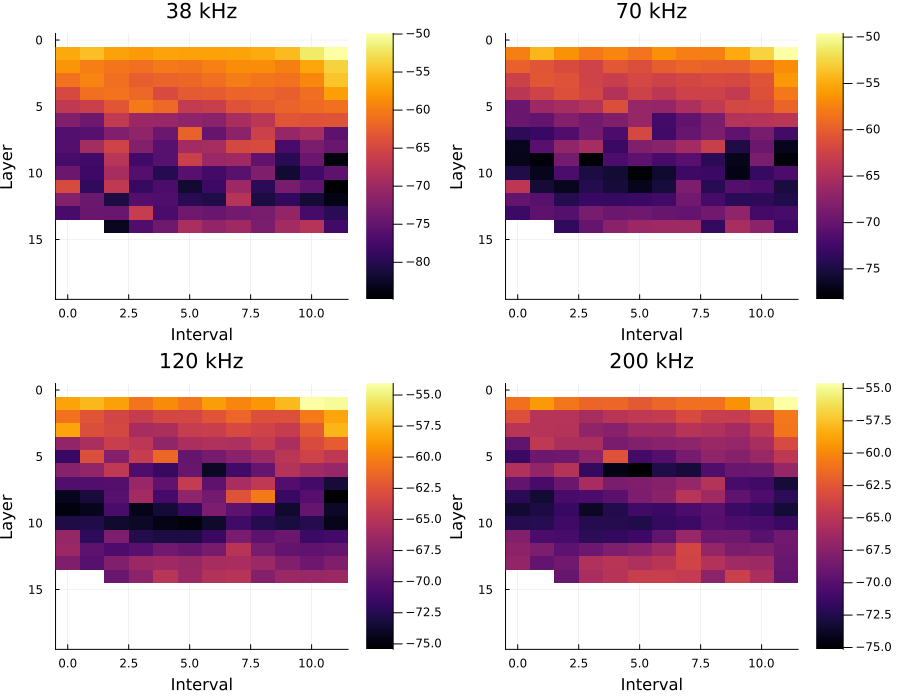

In [5]:
# Set the dimensions of the data
@dim Z YDim "Layer" 
@dim D XDim "Interval" 

# Remake 'echo' including those names
echo = unstack_echogram(Main.eval(bigDF), :interval, :layer, :frequency, :mean_Sv, D, Z);
print("Size of Dimension Layer/Interval/Frequency: $(size(echo))")

# Build and plot the integration data heatmaps
echos = [heatmap(echo[F(Near(f))],yflip=true) for f in [38000,70000,120000,200000]];
plot(echos...,size=(900,700),title=["38 kHz" "70 kHz" "120 kHz" "200 kHz"],layout=(2,2),colorbar=true,fmt = :png)

### 5. Build reference frequency responses

For this simplified example, target strength curves are parameterized and modeled for fish, krill, and jellyfish using the target_strength function in the SDWBA Julia package. The `params` tuple is created to provide priors for use in the model in the next step. In survey implementations, this parameterization occurs using trawl catch data and associated TS relationships.

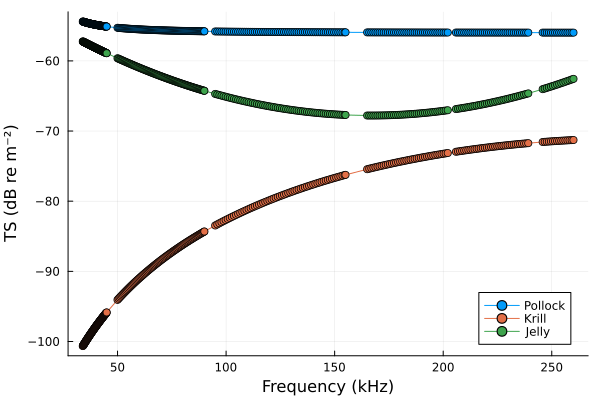

In [6]:
# Get the unique frequencies
freqs = unique(bigDF.frequency)

depth = 50.0
a = 0.0005
δ = 0.5
fish = Bubble(a, depth=depth, δ=δ)
krill = resize(Models.krill_mcgeehee,0.025)
# EBS/GOA average values from Lucca et al. 2021
krill.g .= 1.019
krill.h .= 1.032

ts_fish(freq) = target_strength(fish, freq)
ts_krill(freq) = target_strength(krill, freq, 1470)
ts_jelly(freq) =  (6e-10*(freq^2) - 0.0002*freq +8.9785)-60.1

TS = [ts_fish.(freqs) ts_krill.(freqs) ts_jelly.(freqs)];
params = (; TS);

plot(freqs/1e3, TS,label=["Pollock" "Krill" "Jelly"],
    xlabel="Frequency (kHz)", marker=:circle,ylabel="TS (dB re m⁻²)")

### 6. Run the inversion model

In [7]:
@everywhere begin
    @model function examplemodel(data, params)

        nfreq, nspp = size(params.TS) 
        Σ = exp10.(params.TS ./ 10) # TS is converted to sigma bs

        # define priors
        logn ~ arraydist(Normal.(zeros(nspp), fill(3, nspp))) # scatterer log-densities
        ϵ ~ Exponential(1.0) # observation error variance

        # Predict Sv based on scatterer density and TS
        n = exp10.(logn)
        μ = 10log10.(Σ * n)

        # Compare observed to predicted backscatter
        #for i in findall(!ismissing, data.backscatter)
        #    data.backscatter[i] .~ Normal.(μ, fill(ϵ, nfreq))
        #end
        data.backscatter .~ Normal.(μ, fill(ϵ, nfreq))
    end
end

# Note, for speed, this examples uses MAPSolver in place of MCMC
solution_map = apes(echo, examplemodel, MAPSolver(), params=params);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


### Model output

First the log abundance of each predicted class.

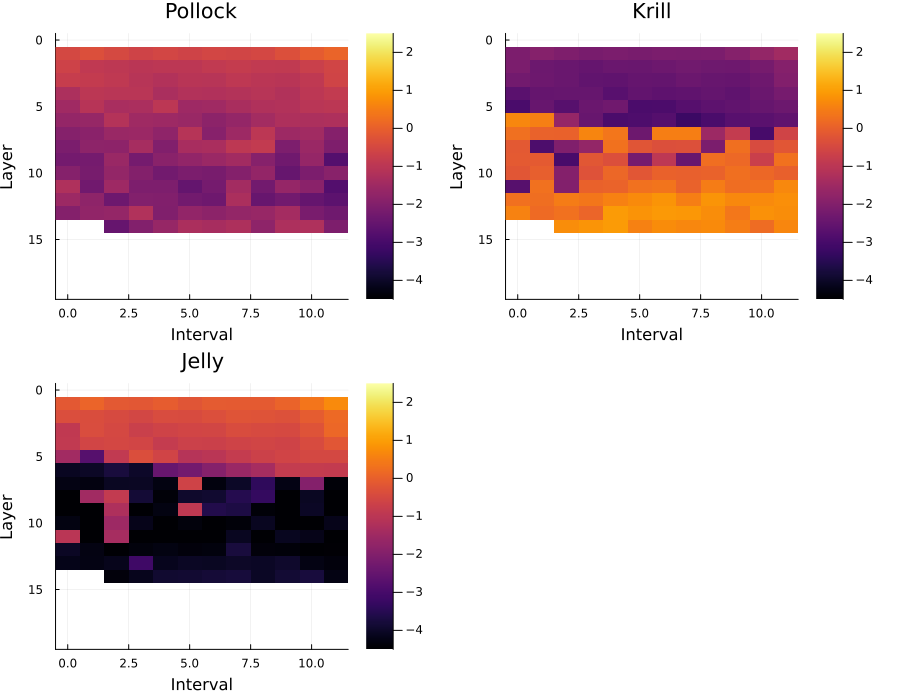

In [8]:
post_mean = passmissing(mean).(solution_map);
masked_post_mean = copy(post_mean)
nan_positions = findall(isnan.(echo[F(Near(freqs[1]))]))
for pos in nan_positions
    masked_post_mean[pos] = fill(NaN, 4)  # Create a Vector{Float64} with all NaN values
end

post_cv = passmissing(cv).(solution_map);

ps = Array{Any}(nothing, size(params.TS)[2])
map(1:size(params.TS)[2]) do s
    h  =[c[s] for c in masked_post_mean]
    ps[s] = heatmap(h,yflip=true,clim=(-4.5,2.5))
end
plot(ps...,title=["Pollock" "Krill" "Jelly"],size=(900,700))

Additionally, we can retrieve the CV by class.

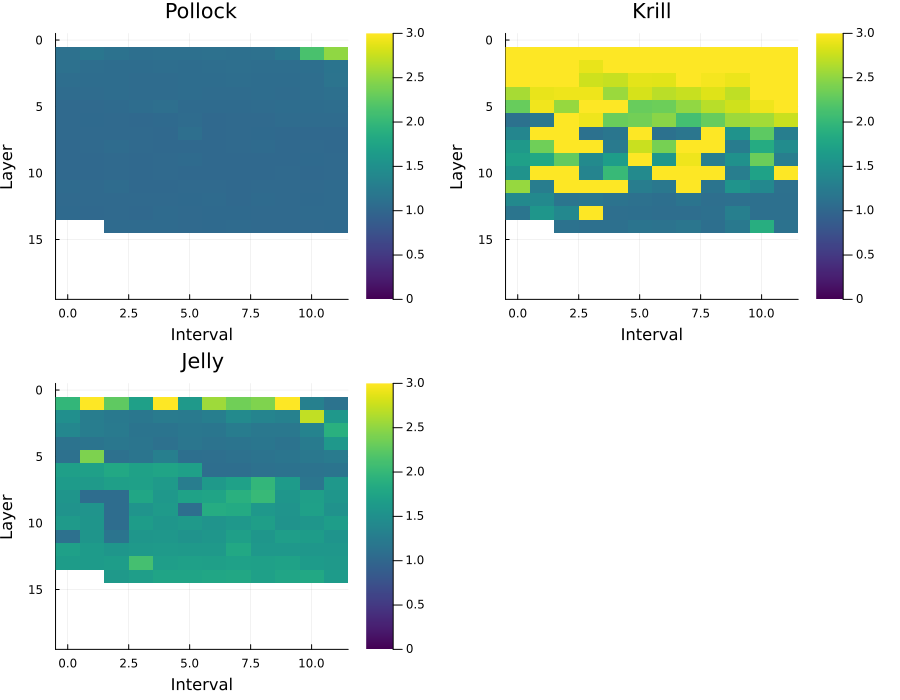

In [9]:
cv_plots = Array{Any}(nothing, size(params.TS)[2])
map(1:size(params.TS)[2]) do s
    h  =[10^(c[s]) for c in post_cv]
    cv_plots[s] = heatmap(h,yflip=true,clim=(0,3),c = :viridis)
end

plot(cv_plots...,title=["Pollock" "Krill" "Jelly"],size=(900,700))